# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Check for GPU
!nvidia-smi

Thu Feb 23 21:57:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

1.13.1+cu116


'cuda'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

1. Training for longer. It may be that the model didn't have enough training to adjust properly to the data, so training for longer, increasing the number of epochs for example, could enhance it's performance.
2. Increase model's capacity. The model may be too simple to adjust to the non-linearity of data. So, it may be that increasing it's capacity, adding more layers, more hidden units for example, can help the model to fit the training data.
3. Get more relevant training data. It may be that the training data don't represent well the testing data, so the model would not be able to generalize enough. Then, it could be better to get more relevant data, via data augmentation for example, so that the model can increase it's overall performance. 

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [3]:
# 1. Get data
import requests
import zipfile
from pathlib import Path

DATA_PATH = Path("data/")
IMAGE_PATH = DATA_PATH / "pizza_steak_sushi"

if IMAGE_PATH.exists():
  print(f"{IMAGE_PATH} já existe.")
else:
  print(f"{IMAGE_PATH} não existe. Criando...")
  IMAGE_PATH.mkdir(parents=True, exist_ok=True)
    
with open(DATA_PATH / "pizza_steak_sushi.zip", "wb") as f:
  raw_link = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
  request = requests.get(raw_link)
  print("Realizando download dos dados...")
  f.write(request.content)

with zipfile.ZipFile(DATA_PATH / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Extraindo dados...") 
        zip_ref.extractall(IMAGE_PATH)

data/pizza_steak_sushi não existe. Criando...
Realizando download dos dados...
Extraindo dados...


In [4]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(IMAGE_PATH)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.


In [5]:
# Setup train and testing paths
TRAIN_PATH = IMAGE_PATH / 'train'
TEST_PATH = IMAGE_PATH / 'test'

Random image path: data/pizza_steak_sushi/test/steak/1882831.jpg
Image class: steak
Image height: 512
Image width: 306


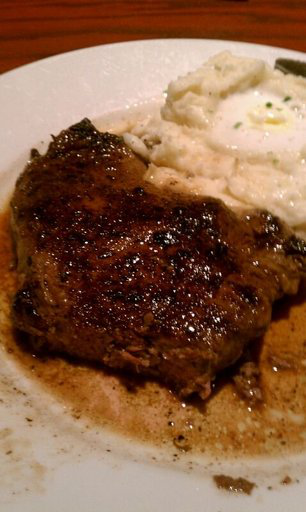

In [6]:
# Visualize an image
import random
from PIL import Image

random.seed(42)

image_path_list = list(IMAGE_PATH.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

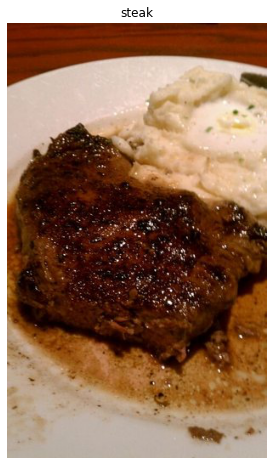

In [11]:
# Do the image visualization with matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 8))
plt.imshow(img)
plt.title(image_class)
plt.axis(False);

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [12]:
# 3.1 Transforming data with torchvision.transforms
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [23]:
# Write transform for turning images into tensors
train_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [18]:
# Write a function to plot transformed images
def transform_and_plot(image_path:str, transform:transforms):
  with Image.open(image_path) as img:
    transformed_image = transform(img)

    image_class = Path(image_path).parent.stem

    plt.figure(figsize=(6, 8))
    plt.imshow(transformed_image.permute(1, 2, 0))
    plt.title(image_class)
    plt.axis(False)

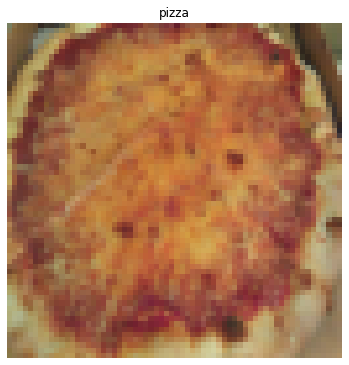

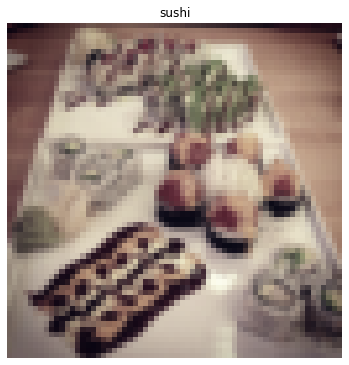

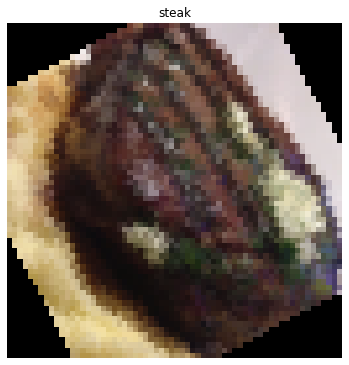

In [39]:
NUM_IMGS = 3
for _ in range(NUM_IMGS):
  random_image_path = random.choice(image_path_list)
  transform_and_plot(random_image_path, train_transform)

### Load image data using `ImageFolder`

In [28]:
# Use ImageFolder to create dataset(s)
train_dataset = datasets.ImageFolder(root=TRAIN_PATH,
                                     transform=train_transform,
                                     target_transform=None
                                     )
test_dataset = datasets.ImageFolder(root=TEST_PATH,
                                     transform=test_transform,
                                     target_transform=None
                                    )

In [29]:
# Get class names as a list
class_names = train_dataset.classes
class_names

['pizza', 'steak', 'sushi']

In [30]:
# Can also get class names as a dict
class_dict = train_dataset.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [31]:
# Check the lengths of each dataset
len(train_dataset), len(test_dataset)

(225, 75)

In [34]:
# Turn train and test Datasets into DataLoaders
import os
torch.manual_seed(42)
BATCH_SIZE = 16
NUM_WORKERS=os.cpu_count()
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS
                              )
test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=NUM_WORKERS
                              )

In [35]:
# How many batches of images are in our data loaders?
len(train_dataloader), len(test_dataloader)

(15, 5)

## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [69]:
from torch import nn
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from: 
  https://poloclub.github.io/cnn-explainer/
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, 
                  out_channels=hidden_units, 
                  kernel_size=3, # how big is the square that's going over the image?
                  stride=1, # default
                  padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, 
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                      stride=2) # default stride value is same as kernel_size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        # Where did this in_features shape come from? 
        # It's because each layer of our network compresses and changes the shape of our inputs data.
        nn.Linear(in_features=hidden_units*16*16,
                  out_features=output_shape)
    )
  
  def forward(self, x: torch.Tensor):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x

def get_base_model():

  torch.manual_seed(42)
  model = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_dataset.classes)).to(device)
  return model

model_0 = get_base_model()
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

## 4. Create training and testing functions for `model_0`.

In [65]:
def logits_to_label(pred_logits):
  return torch.argmax(torch.softmax(pred_logits, dim=1), dim=1)

def get_acc(pred_labels, target_labels):
  return (pred_labels==target_labels).sum().item() / len(pred_labels)

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device:str = 'cpu'):
  
  model.to(device)

  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for X, y in dataloader:
 
    # Send data to target device
    X, y = X.to(device), y.to(device)
    # 1. Forward pass
    pred_logits = model(X)
    # 2. Calculate and accumulate loss
    loss = loss_fn(pred_logits, y)
    train_loss += loss.to('cpu').item()

    # 3. Optimizer zero grad 
    optimizer.zero_grad()

    # 4. Loss backward 
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumulate accuracy metric across all batches
    pred_label = logits_to_label(pred_logits)
    train_acc += get_acc(pred_label, y)

  # Adjust metrics to get average loss and average accuracy per batch
  num_batches = len(dataloader)
  train_loss /= num_batches
  train_acc /= num_batches
  return train_loss, train_acc

In [66]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: str = 'cpu'):
  
  model.to(device)
  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for X, y in dataloader:
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      pred_logits = model(X)

      # 2. Calculate and accumulate loss
      loss = loss_fn(pred_logits, y)
      test_loss += loss.to('cpu').item()

      # Calculate and accumulate accuracy
      pred_label = logits_to_label(pred_logits)
      test_acc += get_acc(pred_label, y)

    
  # Adjust metrics to get average loss and accuracy per batch
  num_batches = len(dataloader)
  test_loss /= num_batches
  test_acc /= num_batches
  return test_loss, test_acc

In [67]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  
  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model, 
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    # Test step
    test_loss, test_acc = test_step(model=model, 
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)
    
    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer. 

In [72]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_0_0 = get_base_model()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0_0.parameters(), 
                             lr=0.001)

model_results_5_epochs= train(model=model_0_0,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1074 | train_acc: 0.2583 | test_loss: 1.1266 | test_acc: 0.3125
Epoch: 2 | train_loss: 1.0966 | train_acc: 0.3833 | test_loss: 1.1194 | test_acc: 0.2375
Epoch: 3 | train_loss: 1.1026 | train_acc: 0.3125 | test_loss: 1.1171 | test_acc: 0.2375
Epoch: 4 | train_loss: 1.1009 | train_acc: 0.3250 | test_loss: 1.0969 | test_acc: 0.3625
Epoch: 5 | train_loss: 1.0937 | train_acc: 0.3792 | test_loss: 1.1099 | test_acc: 0.4125


In [73]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_0_1 = get_base_model()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0_1.parameters(), 
                             lr=0.001)
model_results_20_epochs= train(model=model_0_1,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1074 | train_acc: 0.2583 | test_loss: 1.1266 | test_acc: 0.3125
Epoch: 2 | train_loss: 1.0966 | train_acc: 0.3833 | test_loss: 1.1192 | test_acc: 0.2375
Epoch: 3 | train_loss: 1.1032 | train_acc: 0.3125 | test_loss: 1.1178 | test_acc: 0.2375
Epoch: 4 | train_loss: 1.0991 | train_acc: 0.3708 | test_loss: 1.1034 | test_acc: 0.3625
Epoch: 5 | train_loss: 1.0915 | train_acc: 0.3958 | test_loss: 1.1079 | test_acc: 0.3500
Epoch: 6 | train_loss: 1.0732 | train_acc: 0.4667 | test_loss: 1.1347 | test_acc: 0.2500
Epoch: 7 | train_loss: 1.0670 | train_acc: 0.3958 | test_loss: 1.0744 | test_acc: 0.3807
Epoch: 8 | train_loss: 1.0567 | train_acc: 0.4917 | test_loss: 0.9915 | test_acc: 0.5023
Epoch: 9 | train_loss: 1.0071 | train_acc: 0.4667 | test_loss: 1.0422 | test_acc: 0.5023
Epoch: 10 | train_loss: 1.0104 | train_acc: 0.4875 | test_loss: 0.9789 | test_acc: 0.4284
Epoch: 11 | train_loss: 0.9855 | train_acc: 0.5083 | test_loss: 1.0074 | test_acc: 0.4170
Epoch: 12 | train_l

In [74]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_0_2 = get_base_model()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0_2.parameters(), 
                             lr=0.001)

model_results_50_epochs= train(model=model_0_2,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1074 | train_acc: 0.2583 | test_loss: 1.1266 | test_acc: 0.3125
Epoch: 2 | train_loss: 1.0966 | train_acc: 0.3833 | test_loss: 1.1194 | test_acc: 0.2375
Epoch: 3 | train_loss: 1.1029 | train_acc: 0.3125 | test_loss: 1.1176 | test_acc: 0.2375
Epoch: 4 | train_loss: 1.1009 | train_acc: 0.3042 | test_loss: 1.0959 | test_acc: 0.3625
Epoch: 5 | train_loss: 1.0918 | train_acc: 0.3792 | test_loss: 1.1100 | test_acc: 0.4375
Epoch: 6 | train_loss: 1.0833 | train_acc: 0.3875 | test_loss: 1.1095 | test_acc: 0.3250
Epoch: 7 | train_loss: 1.0569 | train_acc: 0.4083 | test_loss: 1.0516 | test_acc: 0.3375
Epoch: 8 | train_loss: 1.0242 | train_acc: 0.4625 | test_loss: 1.0226 | test_acc: 0.4670
Epoch: 9 | train_loss: 0.9795 | train_acc: 0.4792 | test_loss: 0.9941 | test_acc: 0.4398
Epoch: 10 | train_loss: 1.0110 | train_acc: 0.4833 | test_loss: 0.9762 | test_acc: 0.4341
Epoch: 11 | train_loss: 0.9844 | train_acc: 0.5792 | test_loss: 0.9974 | test_acc: 0.4909
Epoch: 12 | train_l

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [76]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1 = TinyVGG(input_shape=3,
                  hidden_units=20,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), 
                             lr=0.001)

model_1_20_epochs_results = train(model=model_1,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0975 | train_acc: 0.4083 | test_loss: 1.0997 | test_acc: 0.3125
Epoch: 2 | train_loss: 1.1136 | train_acc: 0.3250 | test_loss: 1.0975 | test_acc: 0.3500
Epoch: 3 | train_loss: 1.1010 | train_acc: 0.3208 | test_loss: 1.1024 | test_acc: 0.2750
Epoch: 4 | train_loss: 1.0951 | train_acc: 0.4542 | test_loss: 1.0819 | test_acc: 0.3864
Epoch: 5 | train_loss: 1.0441 | train_acc: 0.5208 | test_loss: 1.0098 | test_acc: 0.4409
Epoch: 6 | train_loss: 1.0065 | train_acc: 0.5083 | test_loss: 1.1344 | test_acc: 0.3500
Epoch: 7 | train_loss: 1.0699 | train_acc: 0.4417 | test_loss: 0.9907 | test_acc: 0.4648
Epoch: 8 | train_loss: 0.9751 | train_acc: 0.5250 | test_loss: 1.0389 | test_acc: 0.4307
Epoch: 9 | train_loss: 1.0059 | train_acc: 0.4458 | test_loss: 0.9809 | test_acc: 0.4864
Epoch: 10 | train_loss: 0.9580 | train_acc: 0.5125 | test_loss: 0.9839 | test_acc: 0.5148
Epoch: 11 | train_loss: 0.9008 | train_acc: 0.5833 | test_loss: 1.0289 | test_acc: 0.4182
Epoch: 12 | train_l

It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [77]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...") 
    zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


In [78]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/test'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/sushi'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/pizza'.
There are 0 directories and 58 images in 'data/pizza_steak_sushi_20_percent/test/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/train'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi_20_percent/train/sushi'.
There are 0 directories and 154 images in 'data/pizza_steak_sushi_20_percent/train/pizza'.
There are 0 directories and 146 images in 'data/pizza_steak_sushi_20_percent/train/steak'.


Excellent, we now have double the training and testing images... 

In [79]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [81]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),                                     
  transforms.ToTensor()
])

# Create datasets
train_20_datasets = ImageFolder(root=train_data_20_percent_path, 
                                transform=simple_transform)

test_20_datasets = ImageFolder(root=test_data_20_percent_path, 
                                transform=simple_transform)

# Create dataloaders
train_20_dataloader = DataLoader(dataset=train_20_datasets,
                                 batch_size=BATCH_SIZE,
                                 shuffle=True,
                                 num_workers=NUM_WORKERS)

test_20_dataloader = DataLoader(dataset=test_20_datasets,
                                 batch_size=BATCH_SIZE,
                                 shuffle=True,
                                 num_workers=NUM_WORKERS)

In [82]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1_1 = TinyVGG(input_shape=3,
                  hidden_units=20,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1_1.parameters(), 
                             lr=0.001)

model_1_1_20_epochs_results = train(model=model_1_1,
      train_dataloader=train_20_dataloader,
      test_dataloader=test_20_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1046 | train_acc: 0.3362 | test_loss: 1.0962 | test_acc: 0.3500
Epoch: 2 | train_loss: 1.0203 | train_acc: 0.5280 | test_loss: 0.9062 | test_acc: 0.5646
Epoch: 3 | train_loss: 0.9360 | train_acc: 0.5733 | test_loss: 0.9234 | test_acc: 0.5375
Epoch: 4 | train_loss: 0.8617 | train_acc: 0.6358 | test_loss: 0.8862 | test_acc: 0.5417
Epoch: 5 | train_loss: 0.8869 | train_acc: 0.6121 | test_loss: 0.8766 | test_acc: 0.6167
Epoch: 6 | train_loss: 0.8405 | train_acc: 0.6487 | test_loss: 0.8906 | test_acc: 0.5875
Epoch: 7 | train_loss: 0.8066 | train_acc: 0.6379 | test_loss: 0.8752 | test_acc: 0.5292
Epoch: 8 | train_loss: 0.7760 | train_acc: 0.6616 | test_loss: 0.8730 | test_acc: 0.5813
Epoch: 9 | train_loss: 0.7126 | train_acc: 0.7069 | test_loss: 0.8626 | test_acc: 0.6312
Epoch: 10 | train_loss: 0.7064 | train_acc: 0.7047 | test_loss: 0.9240 | test_acc: 0.5604
Epoch: 11 | train_loss: 0.6546 | train_acc: 0.7457 | test_loss: 0.9438 | test_acc: 0.5500
Epoch: 12 | train_l

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction. 
* Does the model you trained in exercise 7 get it right? 
* If not, what do you think you could do to improve it?

In [88]:
data_path = Path("data/")
image_path = data_path / "custom"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
# Download custom img
custom_image_path = image_path / "pizza_1.jpeg"
with open(custom_image_path, "wb") as f:
  link = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg"
  request = requests.get(link)
  print("Downloading custom img...")
  f.write(request.content)

data/custom directory exists.


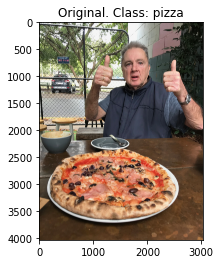

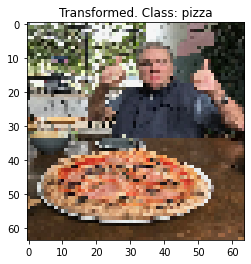

In [97]:
import torchvision

custom_image = torchvision.io.read_image(str(custom_image_path))

plt.imshow(custom_image.permute(1, 2, 0))
plt.title("Original. Class: pizza")
plt.show();

custom_image = custom_image / 255
custom_img_transformer = transforms.Resize(size=(64, 64))
transformed_img = custom_img_transformer(custom_image)

plt.imshow(transformed_img.permute(1, 2, 0))
plt.title("Transformed. Class: pizza")
plt.show();

In [101]:
model_1_1.eval()
with torch.inference_mode():
  input_image = transformed_img.unsqueeze(0).to(device)
  pred_logits = model_1_1(input_image)

  pred_label = logits_to_label(pred_logits)

  pred_class = class_names[pred_label]
  print(pred_class) 

steak


It wrongly predicted that the pizza image is a steak. I would have to find other ways to improve the model's performance.